In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


2024-02-16 00:14:49.522692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 00:14:49.523147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 00:14:49.539389: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2024-02-16 00:15:06.603882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 00:15:06.604241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


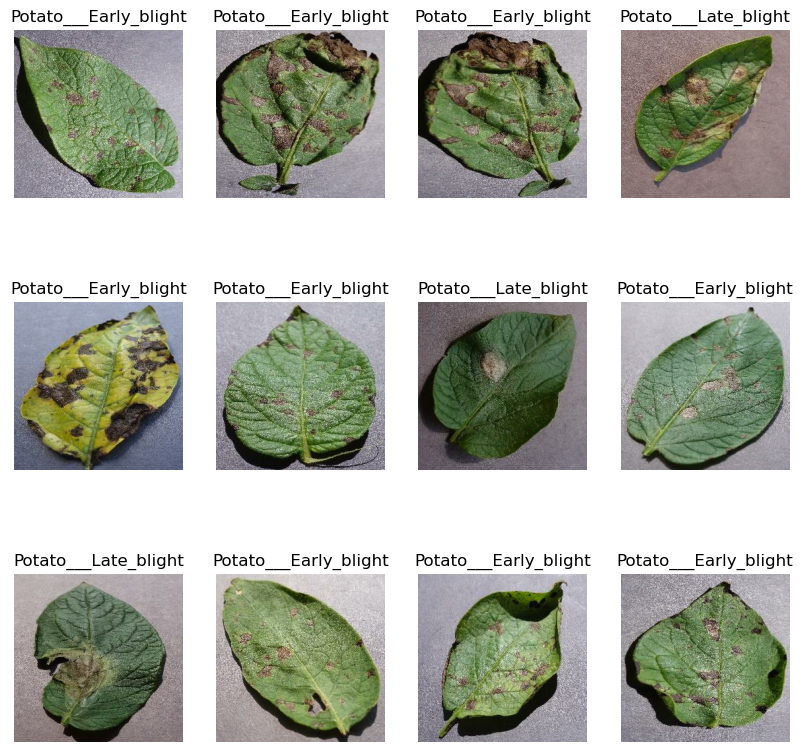

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
#going to split the dataset (the length of the dataset is 68 and each element has batch of 32)
# 80% => training 
# 20% => 10% validation (after each epoch this 10% validation dataset is used), 10% for testing
# at the end of every epoch, we use this above 10% validation dataset, in total there will be 50 epochs. 
# only once after the 50 epochs are done, then we use the 10% testing dataset to test the accuracy and performancy
# of the model. 


In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54) # you are skipping the first 54 batches and now you considering everything after the first 54 batches
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
# see recommended list of videos as to why suffle size has been set to 10000 in the loop

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
#watch video to understand caching and prefetching-> very important

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# this will read the image from the disk and during the next iteration when the image is required, it will improve memory and improve performance of pipeline 
# prefetch will load the next set of data/images (watch video called preferch and cache in deep learning # 44 tutorial)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
# first thing to do in image processing is to scale things first
# numpy is in the range of 255, numpy array is between 0 and 255 (rgb scale), you divide 
# this by 255 to get a number between 0 and 1
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255)
]) # this will scale the image to whats required (255) I think

In [27]:
# once this layer above is created for our model
# to make the model robust, for example when u try predicting an image but that image is darkened or deformed (upside down)
# also, so if ur model is not robus it would do a bad job in predicting what the model does and hence the goal is now 
# to make the model more robust: we use data augmentation for this (again watch this video as well)
# how it basically works: take one image and create training samples out of it by rotating, horizontally flipping it, 
# changing the contrast, zooming in or out

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
# to summarize what has been done till now in the project: 
# - loaded our dataset into tensorflow dataset
# - did some visualization
# did trai, test and validate 
# created layers for preprocessing of data
# basically we manipulated our data in such a way that it is now ready for model training
# NOW, below we are going to create a Convolutional Neural Network (CNN) and train the network on our train data set 
# and measure accuracy using test dataset
# CNNs are typically used when dealing with image classification models(watch Convolutional Neural Network video also)

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
#the numbers 32, 64, .... represent the number of neurons for each layers
# softmax will normalize the probability of your classes

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [32]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


2024-02-16 00:18:41.281625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 00:18:41.282201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.5231

2024-02-16 00:20:32.052781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 00:20:32.053351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - 117s 2s/step - loss: 0.9016 - accuracy: 0.5231 - val_loss: 0.8130 - val_accuracy: 0.6562
Epoch 2/50
54/54 [==============================] - 114s 2s/step - loss: 0.6167 - accuracy: 0.7454 - val_loss: 0.4662 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 104s 2s/step - loss: 0.3917 - accuracy: 0.8397 - val_loss: 0.4074 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 107s 2s/step - loss: 0.2256 - accuracy: 0.9167 - val_loss: 0.2555 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 120s 2s/step - loss: 0.1980 - accuracy: 0.9190 - val_loss: 0.1026 - val_accuracy: 0.9531
Epoch 6/50
54/54 [==============================] - 127s 2s/step - loss: 0.0981 - accuracy: 0.9618 - val_loss: 0.0463 - val_accuracy: 0.9844
Epoch 7/50
54/54 [==============================] - 106s 2s/step - loss: 0.0918 - accuracy: 0.9635 - val_loss: 0.0883 - val_accuracy: 0.9740
Epoch 8/50
54/54 [======

In [33]:
scores = model.evaluate(test_ds)

2024-02-16 01:30:52.072442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]
2024-02-16 01:30:52.074256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 2s 165ms/step - loss: 0.1139 - accuracy: 0.9961


In [34]:
scores

[0.11393971741199493, 0.99609375]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [37]:
history.history.keys()
# the 4 parameters are the numbers you get written after running each epoch 
# so since there are 15 epochs that means for all of the 4 parameters there will be 15 values (so in total there would be 60).


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
history.history['accuracy']
# this returns a list of numbers

[0.5231481194496155,
 0.7453703880310059,
 0.8396990895271301,
 0.9166666865348816,
 0.9189814925193787,
 0.9618055820465088,
 0.9635416865348816,
 0.96875,
 0.9398148059844971,
 0.9785879850387573,
 0.9791666865348816,
 0.9866898059844971,
 0.9901620149612427,
 0.9820601940155029,
 0.9728009104728699,
 0.9959490895271301,
 0.9988425970077515,
 0.9913194179534912,
 0.9849537014961243,
 0.9982638955116272,
 0.9976851940155029,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [39]:
# the above can be plotted so as to give better visualization using the matplot library
# understand the difference between accuracy and val_accuracy (personal research for me)
# also do the same for history and val_loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# all of the above basically return a list of all the 15 different values for the respective parameters.

In [40]:
print(val_loss)

[0.8129608631134033, 0.4662035405635834, 0.4074019491672516, 0.25554442405700684, 0.10257745534181595, 0.04628930985927582, 0.08828545361757278, 0.19360776245594025, 0.12392977625131607, 0.10766329616308212, 0.02049150876700878, 0.09829771518707275, 0.05614796280860901, 0.14215464890003204, 0.030232571065425873, 0.008633725345134735, 0.00767982704564929, 0.06607692688703537, 0.07414650171995163, 0.013645629398524761, 0.007753702346235514, 0.008741622790694237, 0.011698171496391296, 0.005107674282044172, 0.0060876235365867615, 0.006771750282496214, 0.005910422652959824, 0.00884587224572897, 0.007715232204645872, 0.006081321742385626, 0.006136834155768156, 0.008282357826828957, 0.006120849400758743, 0.00579300569370389, 0.007182262372225523, 0.007127141579985619, 0.0062362696044147015, 0.006670522037893534, 0.007515450473874807, 0.007950781844556332, 0.005996552761644125, 0.006622753571718931, 0.006239416543394327, 0.006067623849958181, 0.007210846990346909, 0.007088987622410059, 0.00699

Text(0.5, 1.0, 'Training and Validation Loss')

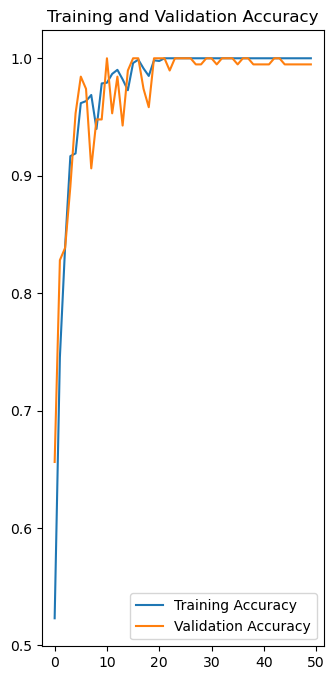

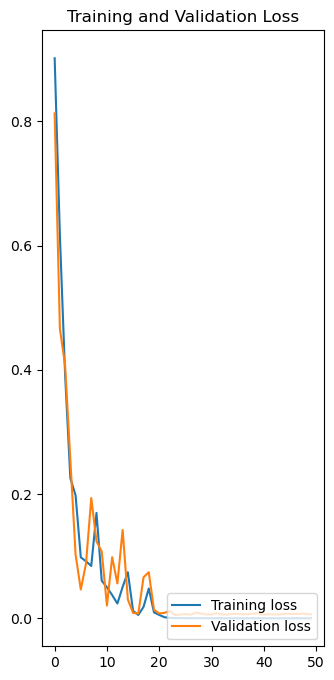

In [41]:
# now below we are going to plot training and validation accuracy 
plt.figure(figsize= (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# watch a matplot lib tutorial also to understand this even more (do some examples also)
# x-axis has the number of epochs

# plotting the loss chart 
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

# as an extension create that true false graphs (forgot the name check ur ee for more details)

# loss is the error in backpropagation which keeps reducing after each epochs


2024-02-16 01:32:07.256425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 01:32:07.257283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


first image to predict
first image's actual label:, Potato___Early_blight
1/1 [==============================] - 0s 222ms/step
predicted label: Potato___Early_blight


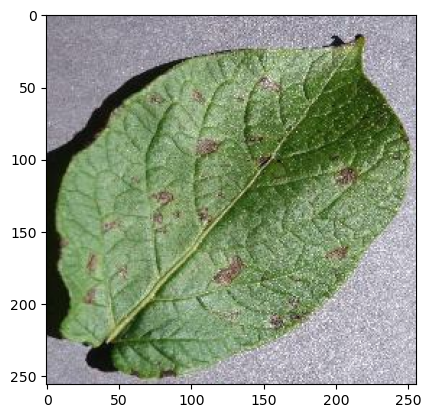

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    #print(images_batch[0].numpy()) # this is currently a tensor, to convert it to numpy use the .numpy() method
    #plt.imshow(images_batch[0].numpy().astype('uint8')) # once converted to numpy to show the image from the dataset directly use the astype('uint8') method
    # if you print the image using the print method instead of the plt.imshow then you get a 3 Dimensional array (RGB). Done below:
    #print(images_batch[0].numpy().astype('uint8')) we are gonna save this as a variable 
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:,", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) # this yields a 3 dimensional array because of the architecture of our model, it has 
    # 3 neurons (softmax produces possibility- highest probality is the class.)

In [ ]:
# understand the difference between numpy and tensor, both are just ordinary numbers but what is the difference between them

In [43]:
# basically just inputs the model and the image and gives you the predicted class and the confidence (similar to what above cell is doing)
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create batch 
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


2024-02-16 01:32:43.804427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 01:32:43.804967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 14ms/step


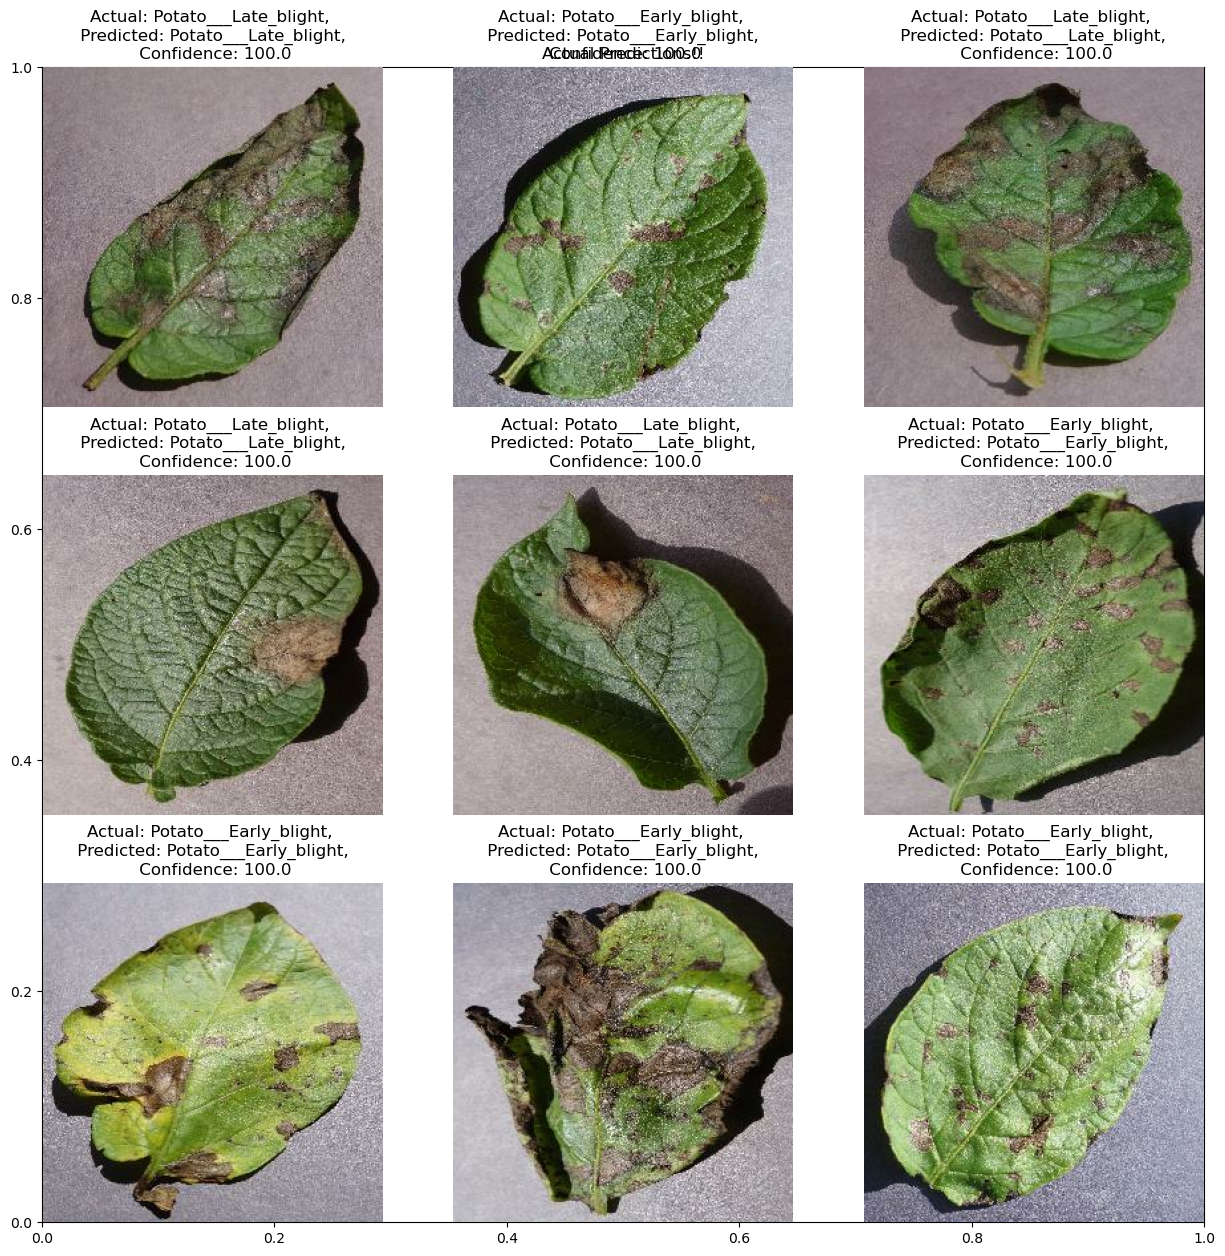

In [44]:
plt.figure(figsize=(15,15)) # this makes the images bigger by increasing their dimensions
plt.title("Actual Predictions!!")
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # to have all of the images you need to have a subplot as well, so below line will not show everything, above line does that for you
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")
        plt.axis("off")

In [46]:
import os 
[int(i) for i in os.listdir("../models")]

FileNotFoundError: [Errno 2] No such file or directory: '../models'